In the last model, switching to a new validation set that was drawn from completely different videos produced poor results. The set was small and needs to be increased in size, but the results were worse than expected. In this model, I will tweak some parameters to see if I can improve the results.

In [1]:
%load_ext autoreload
%autoreload 2
import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.0001
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = False

In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
13081,13082.jpg,0.0,0.0,0.0,0.0,0.0
13082,13083.jpg,0.0,0.0,0.0,0.0,0.0
13083,13084.jpg,0.0,0.0,0.0,0.0,0.0
13084,13085.jpg,0.0,0.0,0.0,0.0,0.0


In [3]:
df_validation = project_utils_multi.load_image_dataframes('./data/validation/', 'annotations.json')
display(df_validation)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
107,00108.jpg,0.0,0.0,0.0,0.0,0.0
108,00109.jpg,0.0,0.0,0.0,0.0,0.0
109,00110.jpg,0.0,0.0,0.0,0.0,0.0
110,00111.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
train_datagen= project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', seed=RANDOM_SEED)
validation_datagen = project_utils_multi.create_data_generators(df_validation, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/validation/', seed=RANDOM_SEED)
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=500))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=1))

In [5]:
pos_neg = project_utils_multi.get_negative_positive_count('./data/train/', 'annotations.json')
print('Total Examples: ', pos_neg['positive'] + pos_neg['negative'])
print('Total positive: ', pos_neg['positive'])
print('Total negative: ', pos_neg['negative'])
print('Train positive: ', train_datagen.get_positive_count())
print('Train negative: ', train_datagen.get_negative_count())
print('Validation positive: ', validation_datagen.get_positive_count())
print('Validation negative: ', validation_datagen.get_negative_count())

Total Examples:  13086
Total positive:  10786
Total negative:  2300
Train positive:  10786
Train negative:  2300
Validation positive:  101
Validation negative:  11


In [6]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

hidden = keras.layers.Dense(1024, activation='relu')(flatten)

# hidden = keras.layers.Dense(512, activation='relu')(flatten)
# hidden = keras.layers.Dropout(0.5)(hidden)
# hidden = keras.layers.Dense(256, activation='relu')(hidden)
# hidden = keras.layers.Dropout(0.25)(hidden)


confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='linear', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.IOU_Metric()]])#, run_eagerly=True)


es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])


Epoch 1/100
408/408 [==============================] - 93s 200ms/step - loss: 71252.1605 - confidence_output_loss: 0.1730 - bounding_output_loss: 71252.0045 - confidence_output_binary_accuracy: 0.8245 - confidence_output_auc: 0.5035 - bounding_output_iou__metric: 0.1961 - val_loss: 23949.8496 - val_confidence_output_loss: 0.1146 - val_bounding_output_loss: 23949.7344 - val_confidence_output_binary_accuracy: 0.8854 - val_confidence_output_auc: 0.5000 - val_bounding_output_iou__metric: 0.3613
Epoch 2/100
408/408 [==============================] - 81s 199ms/step - loss: 23226.1898 - confidence_output_loss: 0.1644 - bounding_output_loss: 23226.0254 - confidence_output_binary_accuracy: 0.8343 - confidence_output_auc: 0.5180 - bounding_output_iou__metric: 0.3953 - val_loss: 26982.7559 - val_confidence_output_loss: 0.1383 - val_bounding_output_loss: 26982.6191 - val_confidence_output_binary_accuracy: 0.8229 - val_confidence_output_auc: 0.9513 - val_bounding_output_iou__metric: 0.3563
Epoch 3/

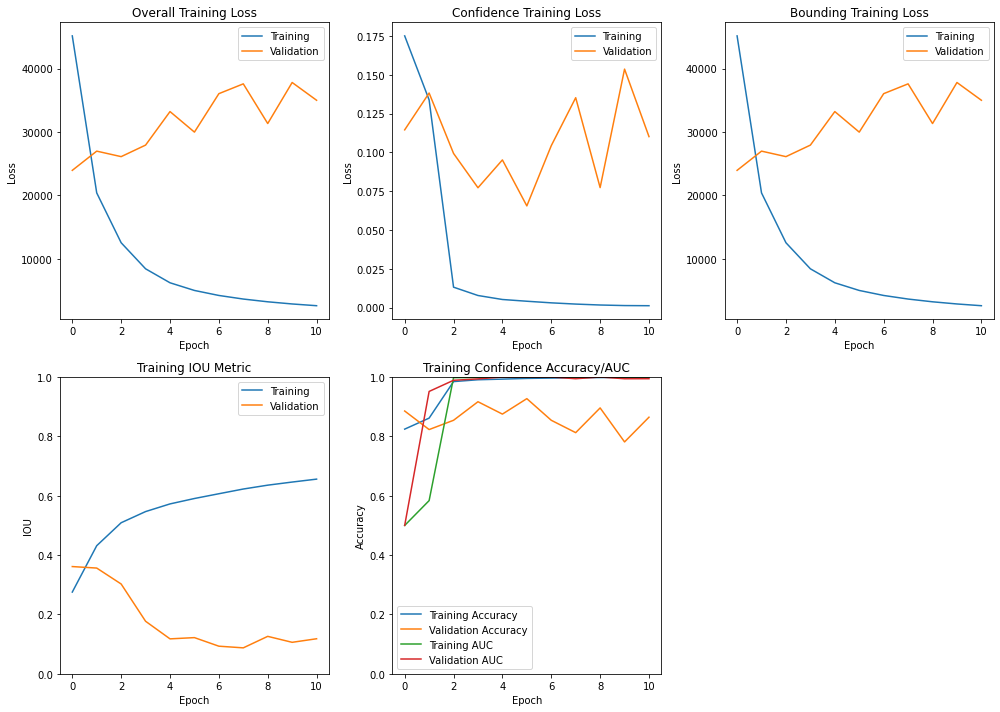

3/3 [==============================] - 1s 181ms/step - loss: 21587.7129 - confidence_output_loss: 0.0938 - bounding_output_loss: 21587.6191 - confidence_output_binary_accuracy: 0.9062 - confidence_output_auc: 0.5000 - bounding_output_iou__metric: 0.3684
Training Loss: 26708.541015625
Training IOU: 0.35492610931396484
Validation Loss: 21587.712890625
Validation IOU: 0.3683999478816986


In [7]:
project_utils_multi.plot_history(history)
train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[-1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[-1]))
project_utils_multi.write_results('./history.txt', model, history, train_datagen, validation_datagen)

In [8]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=500))

In [9]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=1))

In [10]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model))

In [11]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model))